# Training of full dataset and final predictions

In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pyltr
import utils
from operator import itemgetter
import csv
import pickle
import nDCG


## Training settings

In [14]:
balance_flag = True
downsampling_rate = 5
learning_rate = 0.1


## Load dataset and downsampling

In [15]:
# Choose from 0, 1, 2 ,3

# read datasets from correct path
k=0 
train = pd.read_pickle("train_final_0")
val = pd.read_pickle("val_final_0")
test = pd.read_pickle("test_final_0")



In [16]:
use_full_test = False
# Merge test file
if use_full_test:
    df1=pd.read_pickle('test_cleaned_dataset_part14000000')
    df1tail = pd.read_pickle('test_cleaned_dataset_part14000000tail')
    d1 = pd.concat([df1,df1tail], axis=0)

    df2=pd.read_pickle('test_cleaned_dataset_part24000000')
    df2tail = pd.read_pickle('test_cleaned_dataset_part24000000tail')
    d2 = pd.concat([df2,df2tail], axis=0)

    df_test = pd.concat([d1,d2], axis=1)

    test = df_test

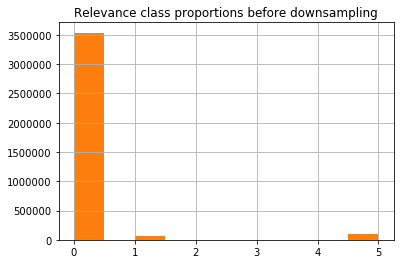

In [17]:
train['relevance'].hist()
plt.title('Relevance class proportions before downsampling')
plt.show()


# balance the dataset, much faster training
if balance_flag:
    train = utils.balance_dataset(train,downsampling_rate)

In [18]:
# Efi's code for data cleaning
train.shape
selected_features = utils.define_features()

In [19]:
features_to_keep = ['booking_bool', 'srch_id', 'click_bool', 'prop_id', 'relevance']
selected_features = list(set(set(selected_features).difference(features_to_keep)))
all_possible_features = features_to_keep + selected_features

all_possible_features = list(set(all_possible_features))
df_to_train = train.ix[:,all_possible_features]
df_to_val = val.ix[:,all_possible_features]
df_to_test = test.ix[:,all_possible_features]

# since we've created a new variable that combined those two, there's no need in keeping them
df_to_train.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_val.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_test.drop(['booking_bool', 'click_bool'], axis = 1)

# rearrange the columns because lambdaMART wants the target variable and the IDs in the first and second column respectively
df_to_train = df_to_train[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_val =  df_to_val[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_test =  df_to_test[['relevance', 'srch_id', 'prop_id']+selected_features]

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [20]:
print(df_to_train.shape, df_to_test.shape)

(683253, 65) (244162, 65)


In [21]:
selected_features

['comp3_rate_percent_diff_signed',
 'prop_review_score_norm_srch_id',
 'prop_location_score_mean',
 'price_usd_norm_srch_destination_id',
 'promotion_flag',
 'value_for_money_star',
 'value_for_money_norm_srch_id',
 'comp7_rate_percent_diff_signed',
 'orig_destination_distance',
 'random_bool',
 'srch_adults_count',
 'prop_starrating_monot',
 'visitor_hist_starrating',
 'srch_room_count',
 'comp6_inv',
 'prop_location_score2_norm_srch_id',
 'prop_log_historical_price',
 'comp5_inv',
 'prop_review_score',
 'prop_starrating',
 'price_usd_norm_srch_id',
 'prop_brand_bool',
 'srch_children_count',
 'comp1_rate_percent_diff_signed',
 'srch_booking_window',
 'price_rank',
 'prop_location_score2_norm',
 'value_for_money_star_norm_srch_destination_id',
 'star_diff_from_historic_mean',
 'srch_destination_id',
 'price_usd_norm_prop_id',
 'srch_query_affinity_score_norm_srch_id',
 'price_usd_norm_srch_saturday_night_bool',
 'price_usd_log',
 'comp6_rate_percent_diff_signed',
 'prop_starrating_nor

## Prepare dataset for model

In [22]:
#From dataframes to arrays
trrelevance_arr = np.array(df_to_train['relevance'])
trfeature_arr = np.array(df_to_train[selected_features])
trid_arr = np.array(df_to_train.srch_id)

vrelevance_arr = np.array(df_to_val['relevance'])
vfeature_arr = np.array(df_to_val[selected_features])
vid_arr = np.array(df_to_val.srch_id)

terelevance_arr = np.array(df_to_test['relevance'])
tefeature_arr = np.array(df_to_test[selected_features])
teid_arr = np.array(df_to_test.srch_id)

## Run LambdaMART model

In [23]:
#Choose nDCG as metric (k arbitrary number)
metric = pyltr.metrics.NDCG(k=31)

#Use validation set, stop_after arbitrary number
# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    vfeature_arr, vrelevance_arr, vid_arr, metric=metric, stop_after=300)

feats = list(df_to_test[selected_features].columns)
feats

#Use lambdaMART - have to find the best values for the parametes
n_estimators = 300
min_samples_leaf=64
model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    #max_features=0.5,
    #query_subsample=0.5,
    #max_leaf_nodes=10,
    min_samples_leaf=min_samples_leaf,
    verbose=1
)


model.fit(trfeature_arr, trrelevance_arr, trid_arr, monitor=monitor)




 Iter  Train score    Remaining                           Monitor Output 
    1       0.6889       72.48m      C:      0.3722 B:      0.3722 S:  0
    2       0.7057       65.45m      C:      0.3903 B:      0.3903 S:  0
    3       0.7055       62.71m      C:      0.3916 B:      0.3916 S:  0
    4       0.7075       61.08m      C:      0.3964 B:      0.3964 S:  0
    5       0.7113       59.78m      C:      0.3981 B:      0.3981 S:  0
    6       0.7175       58.84m      C:      0.4109 B:      0.4109 S:  0
    7       0.7321       57.94m      C:      0.4264 B:      0.4264 S:  0
    8       0.7352       57.13m      C:      0.4302 B:      0.4302 S:  0
    9       0.7416       56.33m      C:      0.4390 B:      0.4390 S:  0
   10       0.7459       55.62m      C:      0.4452 B:      0.4452 S:  0
   15       0.7570       53.09m      C:      0.4635 B:      0.4635 S:  0
   20       0.7659       49.93m      C:      0.4748 B:      0.4748 S:  0
   25       0.7702       46.54m      C:      0.480

In [24]:

from sklearn.externals import joblib
model_fname = "model" + str(n_estimators) + "_final.pkl"
joblib.dump(model, model_fname) 

['model100_final.pkl']

## Predict

In [25]:
use_loaded_model = False
if use_loaded_model:
    model = joblib.load(model_fname)   

if not use_full_test:
    tepred = model.predict(tefeature_arr)
    print('Random ranking:', metric.calc_mean_random(teid_arr, terelevance_arr))
    print('Our model:', metric.calc_mean(teid_arr, terelevance_arr, tepred))

    rand_seed=0



    all_n = (len(df_to_train)+len(df_to_test) + len(df_to_val))/100000
    #Need to add Search and Property IDs to the output (easy)
    with open('result_statistics_final.txt', mode='a+') as f:
        f.write('%s\t%s\t%s\t%s\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.5f\t%s\t%.0f\t'%(k,rand_seed,len(feats), n_estimators, 
                all_n,len(df_to_train)/100000, len(df_to_test)/100000,
                learning_rate,downsampling_rate, metric.calc_mean(teid_arr, terelevance_arr, tepred), balance_flag, min_samples_leaf)) 


    results_df = df_to_test[['srch_id', 'prop_id', 'relevance']].copy()
    results_df['score'] = -1 * tepred

    # predictions = list(-1.0*predictions)
    recommendations = zip(results_df["srch_id"], results_df["prop_id"], results_df['relevance'], results_df['score'])
    utils.write_submission(recommendations, "lambdamart_test.csv")

    path_results = "lambdamart_test.csv"
    nDCG_result = nDCG.compute_ndcg(path_results)
    print(nDCG_result)
    with open('result_statistics_our_nDCG_final.txt', mode='a+') as f:
        f.write('%s\t%s\t%s\t%s\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.5f\t%s\t%.0f\t'%(k,rand_seed,len(feats), n_estimators, 
                all_n,len(df_to_train)/100000, len(df_to_test)/100000,
                learning_rate,downsampling_rate, nDCG_result, balance_flag, min_samples_leaf)) 




Random ranking: 0.34487072290547127
Our model: 0.49720328512559075
0.4979490817865111


## Make predictions for final set

In [179]:
# this is another write_submission than previously, we dont have relevance anymore
if use_full_test:
    tepred = model.predict(tefeature_arr)
    results_df = df_to_test[['srch_id', 'prop_id']].copy()
    results_df['score'] = -1 * tepred

    def write_submission(recommendations, submission_file):
        """
        Function which writes submission, ordered on the probability obtained by the model.
        The columns are SearchId, PropertyId and Relevance    
        """

        global rows
        submission_path = submission_file
        rows = [(srch_id, int(prop_id))
            for srch_id, prop_id, rank_float
            in sorted(recommendations, key=itemgetter(0,2))]
        writer = csv.writer(open(submission_path, "w"), lineterminator="\n")
        writer.writerow(("SearchId", "PropertyId"))
        writer.writerows(rows)

    # predictions = list(-1.0*predictions)
    recommendations = zip(results_df["srch_id"], results_df["prop_id"], results_df['score'])
    path_results = "final_prediction_file.csv"

    write_submission(recommendations, path_results)

